In [80]:
from pysr import PySRRegressor, TemplateExpressionSpec

import matplotlib.pyplot as plt
import numpy as np

import camb

In [81]:
plt.rcParams['font.family'] = 'stixgeneral'

In [82]:
# Load Data

pars     = np.load('CL_data/parameter_test8.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL8.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL8.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [83]:
past_ells = 1000
n_ells = 4998 - past_ells

# Truncate to ignore first 1000 l's
y_pysr = lensed[:, past_ells:]/unlensed[:, past_ells:]  #lensing

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

# Smoothing the Lensing Tail for Training
do_smoothing = True

if do_smoothing:
    y_pysr[:, 249:-250] = np.apply_along_axis(moving_average, axis = 1, arr = y_pysr[:, :])

# Reformatting data
y_pysr = y_pysr.reshape(-1)
# y_pysr : [par1_c502, par1_c503, ..., par1_c5000, par2_c502, ..., par299_c502, ..., par299_c5000]

In [84]:
# Reformatting data
X_ells = np.array([ell for ell in range(past_ells + 2, 5000)])
pars_pysr = pars[:]
X_pysr = np.zeros((y_pysr.shape[0], 3 + 1))  #for the three cosmo parameters plus ells

In [85]:
# Reformatting data
for i in range(100):
    X_pysr[n_ells*i:n_ells*(i+1), :3] = np.tile(pars[i], n_ells).reshape(n_ells, -1)
    X_pysr[n_ells*i:n_ells*(i+1), -1] = X_ells   #final column is ells

# make x3 = ombh2 + omch2 = om0h2
X_pysr[:, 2] = X_pysr[:, 1] + X_pysr[:, 2]  


In [86]:
# Template Function

template = TemplateExpressionSpec(
    expressions = ["g"],
    variable_names = ["x1", "x2", "x3", "x4"],  #H0, ombh2, ombh2+omch2, ells
    parameters = {"beta": 4},  #parameters to vary in the model to create equation - index from 1
    combine = "1 + (beta[1]*(x4/beta[2])^(g(x2, x3)) - 1)*(1 + exp(-(x4-beta[3]*beta[4])/100))^-1"   #find equation of this form
)

# PySR Model

model = PySRRegressor(
    niterations = 100,
    binary_operators = ["+", "-", "*", "pow"],  #allowed operations
    constraints = {'pow': (4, 1), "*": (4, 4)},   #enforces maximum complexities on arguments of operators 
    batching = True, 
    batch_size = 10000, 
    maxsize = 30,
    populations = 20,
    expression_spec = template,
    complexity_of_variables = 2, #global complexity of variables
    procs = 4
)


In [38]:
# Train

model.fit(X_pysr, y_pysr)

/home/flapbat/anaconda3/envs/env_voigt/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 0 / 2000 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Progress: 0 / 2000 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000  g = 0.0; beta = [1.054252, 62.0607, -0.8973328...   
	1   >>>>  0.007337  g = #1 * -0.10728895; beta = [1.0686755, 0.005...   
	2         0.005590  g = (#2 * 0.13988546) - #1; beta = [1.067447, ...   
	3         0.000300  g = (#2 * 0.06783112) + (#1 * -0.5012717); bet...   
	4         0.000208  g = ((#2 * 0.2841189) * #2) + (#1 * -0.3661188...   
	5         0.000266  g = (#2 ^ 0.5979721) - ((#1 + 0.89456797) * (#...   
	6         0.000136  g = (#2 ^ 0.59233075) - ((#1 * 0.038768794) + ...   
	7         0.000880  g = ((#2 ^ 0.6905596) - ((#2 ^ 0.6264274) * (#...   
	8         0.000061  g = ((#2 ^ 0.6894137) - ((0.85858643 + #1) * (...   
	9         0.000043  g = ((#1 + ((#2 ^ 0.69882977) - ((#1 + 0.84100...   
	10        0.000017  g = ((#2 ^ 0.6903196) + ((#2 ^ 0.6919228) - ((...   
	11        0.000115  g = (((#1 + (#2 ^ 0.69882977)) - ((#1 + 0.8410...   
	
	        loss  complexity  
	0   0.006755           1  
	1   0.006607           4  
	2   0.006498           7  
	3   0.006494           9  
	4   0.006490          12  
	5   0.006486          14  
	6   0.006482          19  
	7   0.006476          20  
	8   0.006475          22  
	9   0.006474          28  
	10  0.006474          29  
	11  0.006473          30  
]

  - outputs/20250605_114651_gopqIZ/hall_of_fame.csv



Expressions evaluated per second: 5.600e+01
Progress: 140 / 2000 total iterations (7.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.646e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.4993, 0.5015, 0.13816]
4           6.620e-03  1.282e-03  ╭ g = #1 * 0.41552
                                  ╰ beta = [3.5674, 1.3554, 0.21429]
5           6.594e-03  3.985e-03  ╭ g = #2 + #2
                                  ╰ beta = [1.88, 0.14579, 0.15959]
7           6.538e-03  4.286e-03  ╭ g = (#2 ^ 0.25081) + #2
                                  ╰ beta = [1.4262, 0.14348, 0.12103]
12          6.538e-03  3.815e-07  ╭ g = ((#2 ^ 0.25081) + (0.81879 * #2)) - #1
                                  ╰ beta = [1.4262, 0.14348, 0.12103]
17          6.538e-03  2.265e-07  ╭ 

Progress: 179 / 2000 total iterations (8.950%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.88, 0.14579, 0.15959]
4           6.548e-03  3.824e-03  ╭ g = #2 * 4.3773
                                  ╰ beta = [1.3764, 0.14907, 0.11486]
7           6.538e-03  5.202e-04  ╭ g = (#2 ^ 0.25081) + #2
                                  ╰ beta = [1.4262, 0.14348, 0.12103]
10          6.537e-03  1.762e-05  ╭ g = ((#2 ^ 0.25081) + #2) - #1
                                  ╰ beta = [1.4262, 0.14348, 0.12103]
20          6.536e-03  1.636e-05  ╭ g = #2 - (((#1 * 1.7221) - (#2 ^ 0.24694)) - ((#2 ^ 0.3605) ...
                                  - #1))
                                  ╰ beta = [1.8802, 0.14097, 0.1596]



Expressions evaluated per second: 5.610e+01
Progress: 215 / 2000 total iterations (10.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.543e-03  4.080e-03  ╭ g = #2 ^ 0.041692
                                  ╰ beta = [1.88, 0.14579, 0.15959]
5           6.540e-03  4.742e-04  ╭ g = #2 + #2
                                  ╰ beta = [1.1027, 0.14594, 0.034603]
7           6.538e-03  1.488e-04  ╭ g = (#2 ^ 0.25081) + #2
                                  ╰ beta = [1.4262, 0.14348, 0.12103]
10          6.537e-03  3.217e-05  ╭ g = (#2 ^ 0.25084) + (#2 - #1)
                                  ╰ beta = [1.4264, 0.14314, 0.12008]
20          6.536e-03  1.199e-05  ╭ g = #2 


Expressions evaluated per second: 3.720e+01
Progress: 242 / 2000 total iterations (12.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.543e-03  4.080e-03  ╭ g = #2 ^ 0.041692
                                  ╰ beta = [1.88, 0.14579, 0.15959]
5           6.540e-03  4.742e-04  ╭ g = #2 + #2
                                  ╰ beta = [1.1027, 0.14594, 0.034603]
7           6.537e-03  2.150e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  1.981e-05  ╭ g = (#2 ^ 0.25139) + (#2 - #1)
                                  ╰ beta = [1.4271, 0.14098, 0.12082]
15          6.536e-03  1.847e-05  ╭ g = (#2


Expressions evaluated per second: 4.780e+01
Progress: 275 / 2000 total iterations (13.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.543e-03  4.080e-03  ╭ g = #2 ^ 0.041692
                                  ╰ beta = [1.88, 0.14579, 0.15959]
5           6.540e-03  4.742e-04  ╭ g = #2 + #2
                                  ╰ beta = [1.1027, 0.14594, 0.034603]
7           6.537e-03  2.150e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  1.981e-05  ╭ g = (#2 ^ 0.25139) + (#2 - #1)
                                  ╰ beta = [1.4271, 0.14098, 0.12082]
12          6.536e-03  4.956e-05  ╭ g = ((#


Expressions evaluated per second: 6.930e+01
Progress: 314 / 2000 total iterations (15.700%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.273e-03  ╭ g = #2 ^ 0.25116
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.092e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  2.529e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-03  4.131e-05  ╭ g = ((#2 ^ 0.04346) + #2) - (#1 ^ 0.25132)
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
17          6


Expressions evaluated per second: 6.980e+01
Progress: 358 / 2000 total iterations (17.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.273e-03  ╭ g = #2 ^ 0.25116
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.092e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 5.360e+01
Progress: 376 / 2000 total iterations (18.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.273e-03  ╭ g = #2 ^ 0.25116
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.092e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 3.330e+01
Progress: 395 / 2000 total iterations (19.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.273e-03  ╭ g = #2 ^ 0.25116
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.092e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 3.880e+01
Progress: 419 / 2000 total iterations (20.950%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.274e-03  ╭ g = #2 ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.074e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 4.580e+01
Progress: 435 / 2000 total iterations (21.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.274e-03  ╭ g = #2 ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.074e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 4.680e+01
Progress: 451 / 2000 total iterations (22.550%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.274e-03  ╭ g = #2 ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.074e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 5.250e+01
Progress: 479 / 2000 total iterations (23.950%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
4           6.539e-03  4.274e-03  ╭ g = #2 ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.074e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 0.25116) * 0.97988)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
10          6.536e-03  6.569e-05  ╭ g = (#2 + (#2 ^ 0.25116)) - #1
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
12          6.536e-


Expressions evaluated per second: 7.470e+01
Progress: 535 / 2000 total iterations (26.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.598e-03  3.751e-03  ╭ g = #2
                                  ╰ beta = [1.4267, 0.13718, 0.12169]
4           6.539e-03  4.536e-03  ╭ g = #2 ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
6           6.538e-03  1.010e-04  ╭ g = (#2 * 1.1887) ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
7           6.537e-03  1.201e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.537e-03  5.096e-06  ╭ g = #2 + ((#2 ^ 


Expressions evaluated per second: 6.260e+01
Progress: 584 / 2000 total iterations (29.200%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.549e-03  1.131e-02  ╭ g = #2
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
4           6.538e-03  8.473e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.166e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.489e-03  3.695e-03  ╭ g = (1.0261 * #


Expressions evaluated per second: 6.420e+01
Progress: 622 / 2000 total iterations (31.100%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.549e-03  1.131e-02  ╭ g = #2
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
4           6.538e-03  8.473e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.166e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.489e-03  3.695e-03  ╭ g = (1.0261 * #

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.150e+01
Progress: 665 / 2000 total iterations (33.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.549e-03  1.131e-02  ╭ g = #2
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
4           6.538e-03  8.473e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.166e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]


Expressions evaluated per second: 5.800e+01
Progress: 707 / 2000 total iterations (35.350%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.549e-03  1.131e-02  ╭ g = #2
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
4           6.538e-03  8.473e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.537e-03  1.166e-04  ╭ g = #2 + (#2 ^ 0.25116)
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
9           6.489e-03  3.695e-03  ╭ g = (1.0261 * #


Expressions evaluated per second: 7.050e+01
Progress: 748 / 2000 total iterations (37.400%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.549e-03  1.131e-02  ╭ g = #2
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
4           6.538e-03  8.473e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  8.045e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
12          6.481e-03  1.402e-04  ╭ g = (#2 - (#

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 6.410e+01
Progress: 790 / 2000 total iterations (39.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.545e-03  1.183e-02  ╭ g = #2
                                  ╰ beta = [1.0654, 0.13334, -0.0034395]
4           6.538e-03  5.862e-04  ╭ g = #2 ^ 0.21816
                                  ╰ beta = [1.4263, 0.1353, 0.12115]
6           6.538e-03  1.314e-05  ╭ g = (#2 * 1.9719) ^ 0.25012
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  8.045e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.1

Progress: 828 / 2000 total iterations (41.400%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.545e-03  1.183e-02  ╭ g = #2
                                  ╰ beta = [1.0654, 0.13334, -0.0034395]
4           6.537e-03  6.295e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
12          6.481e-03  1.402e-04  ╭ g = (#2 - (#1 ^ 0.60448)) - (#1 * 0.40463)
          


Expressions evaluated per second: 3.150e+01
Progress: 845 / 2000 total iterations (42.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.545e-03  1.183e-02  ╭ g = #2
                                  ╰ beta = [1.0654, 0.13334, -0.0034395]
4           6.537e-03  6.295e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
12          6.481e-03  1.402e-04  ╭ g = (#2 


Expressions evaluated per second: 6.480e+01
Progress: 897 / 2000 total iterations (44.850%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.545e-03  1.183e-02  ╭ g = #2
                                  ╰ beta = [1.0654, 0.13334, -0.0034395]
4           6.537e-03  6.295e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
12          6.481e-03  1.402e-04  ╭ g = (#2 


Expressions evaluated per second: 5.890e+01
Progress: 934 / 2000 total iterations (46.700%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2 - 


Expressions evaluated per second: 4.950e+01
Progress: 964 / 2000 total iterations (48.200%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2 - 

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.300e+01
Progress: 1015 / 2000 total iterations (50.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0


Expressions evaluated per second: 7.200e+01
Progress: 1055 / 2000 total iterations (52.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2 -

Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.870e+01
Progress: 1105 / 2000 total iterations (55.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0


Expressions evaluated per second: 6.810e+01
Progress: 1145 / 2000 total iterations (57.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2 -


Expressions evaluated per second: 5.880e+01
Progress: 1186 / 2000 total iterations (59.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [1.8791, 0.12632, 0.16007]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2 -


Expressions evaluated per second: 5.720e+01
Progress: 1215 / 2000 total iterations (60.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 6.290e+01
Progress: 1266 / 2000 total iterations (63.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.281e-02  ╭ g = #2
                                  ╰ beta = [1.0467, 0.14228, -0.048748]
4           6.537e-03  1.383e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 6.880e+01
Progress: 1311 / 2000 total iterations (65.550%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 7.290e+01
Progress: 1350 / 2000 total iterations (67.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 5.960e+01
Progress: 1365 / 2000 total iterations (68.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 2.700e+01
Progress: 1381 / 2000 total iterations (69.050%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 2.690e+01
Progress: 1400 / 2000 total iterations (70.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 4.250e+01
Progress: 1433 / 2000 total iterations (71.650%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2


Expressions evaluated per second: 5.440e+01
Progress: 1465 / 2000 total iterations (73.250%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.623e-03  0.000e+00  ╭ g = 0
                                  ╰ beta = [2.6311, 0.0002013, 0.19192]
2           6.539e-03  1.282e-02  ╭ g = #2
                                  ╰ beta = [1.0482, 0.14665, -0.049024]
4           6.537e-03  1.329e-04  ╭ g = #2 ^ 0.80973
                                  ╰ beta = [1.0745, 0.1453, 0.0055188]
6           6.537e-03  1.407e-05  ╭ g = (#2 * 2.3149) ^ 0.31317
                                  ╰ beta = [1.4268, 0.14023, 0.12094]
7           6.485e-03  7.957e-03  ╭ g = #2 - (#1 ^ 0.60266)
                                  ╰ beta = [1.6652, 0.00011951, 0.14882]
9           6.482e-03  2.369e-04  ╭ g = #2

In [40]:
ells = np.array([l for l in range(2, 5000)])

In [41]:
print(model.equations_["equation"][1])

g = #1 * -0.10728895; beta = [1.0686755, 0.005869941, 0.17472969, 0.10059567]


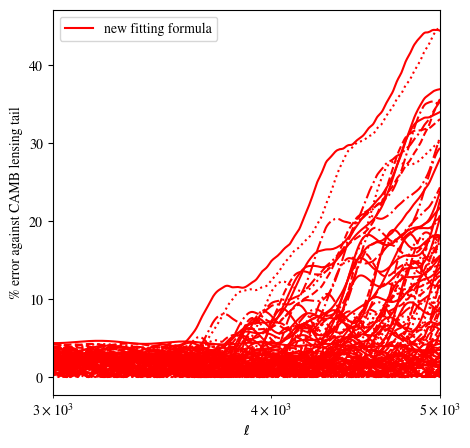

In [87]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

# Final Fit

def lensing_tail_fit(ell, ombh2, omch2):
    beta_1 = 1.0686755   # 0.83
    beta_2 = (0.005869941)    # 1400/0.4531
    beta_3 = 0.17472969   # 1.62
    beta_4 = 0.10059567   #2000

    # Sigmoid
    sigm = (1 + np.exp(-(ell-beta_3*beta_4)/100))**(-1)

    # Exponent
    #alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118
    alpha = ombh2 * -0.10728895

    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)

    L = poly*sigm + 1


    return L


# Fit % Error for 100 Cosmologies
for ind in range(0, 100):
    ax.semilogx(ells, 100*np.abs(lensing_tail_fit(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]), "r", label='new fitting formula')


ax.set_xlim(3000, 5000)
ax.set_xlabel("$\\ell$")

ax.set_ylabel("% error against CAMB lensing tail")


handles, labels = fig.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)


In [88]:
#analysis of the fit

In [121]:
error

[array([2.34290173, 2.27674869, 2.23257428, ..., 3.00966142, 3.0424523 ,
        3.07498988]),
 array([2.75796403, 2.72234013, 2.70062355, ..., 0.996075  , 1.0028961 ,
        1.00990385]),
 array([ 2.41099649,  2.34980952,  2.30927092, ..., 15.39176086,
        15.40869023, 15.42562952]),
 array([2.9103833 , 2.88602829, 2.87260208, ..., 5.49468147, 5.51176247,
        5.52888905]),
 array([2.44520834, 2.38655781, 2.34790068, ..., 4.57848571, 4.56385402,
        4.54863583]),
 array([ 2.9165387 ,  2.8926419 ,  2.87955383, ..., 16.73697798,
        16.75531859, 16.77279636]),
 array([2.86646016, 2.83884894, 2.82302375, ..., 4.26523035, 4.26743843,
        4.26942274]),
 array([ 2.45180652,  2.39362148,  2.35529484, ..., 11.76473036,
        11.77464453, 11.78495591]),
 array([ 2.62905622,  2.58390201,  2.55515877, ..., 17.1901679 ,
        17.17234113, 17.15462099]),
 array([2.73958873, 2.70261079, 2.67989954, ..., 1.33573254, 1.33891615,
        1.34230185]),
 array([ 2.63357824,  2.58

In [129]:
error = [100*np.abs(lensing_tail_fit(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]) for ind in range(0, 100)]

#pars10 = [pars_pysr[i] if np.max(error[i]) > 10 else pass for i in range(0,100)]
#pars10[10][1]
i20 = []
for i in range(len(error)):
    if np.max(error[i])> 20:
        i20.append(i)
i10 = []
for i in range(len(error)):
    if np.max(error[i])> 10:
        i10.append(i)

[11, 26, 27, 28, 29, 34, 35, 55, 56, 58, 60, 63, 65, 76, 79, 80, 87, 95, 98]

In [67]:
# PLOTS BELOW vvvvv

In [68]:
pars = camb.set_params(H0 = 67.4, ombh2 = 0.0224, omch2 = 0.12, lmax=5000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
fiducial_lensed = powers['total'][2:5000, 0]
fiducial_unlensed = powers['unlensed_total'][2:5000, 0]
ells = np.array([l for l in range(2, 5000)])

from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))


<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/80105674.py:38: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$", fontsize = 16)


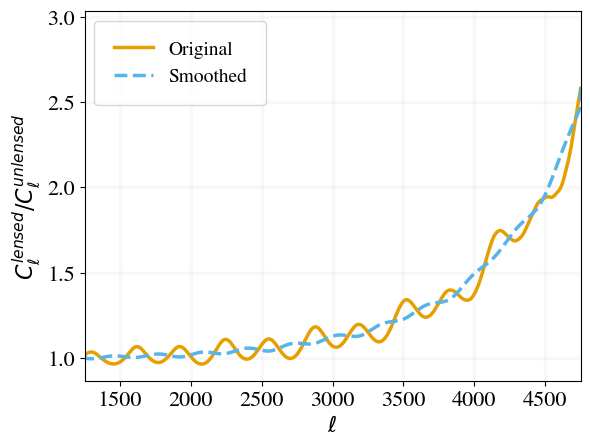

In [69]:
fig, ax = plt.subplots(1, 1)

fiducial_lensing = fiducial_lensed/fiducial_unlensed

#ax.loglog(ells, fiducial_lensing)

past_ells = 1000
n_ells = 4998 - past_ells

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

fiducial_smoothed = np.apply_along_axis(moving_average, axis = 0, arr = fiducial_lensing[1000:])

fiducial_smoothed = np.concatenate((fiducial_lensing[:1250], fiducial_smoothed))
fiducial_smoothed = np.concatenate((fiducial_smoothed, fiducial_lensing[-249:]))

#ax.loglog(ells, fiducial_smoothed)


plt.rc("axes", prop_cycle=line_cycler)


plt.plot(ells, fiducial_lensing, label = f"Original", lw=2.5)
plt.plot(ells, fiducial_smoothed, label = f"Smoothed", lw=2.5)


#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.xlim(1250, 4750)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
plt.legend(loc="upper left", fontsize = 14, borderpad = 1)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_smoothing.pdf", format="pdf", bbox_inches='tight')

In [70]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

par_arr = []
lensing_tails = []

for _ombh2 in ombh2vals:
    for _omch2 in omch2vals:

        par_arr.append((_ombh2, _omch2))
        
        pars = camb.set_params(H0 = 67.4, ombh2 = _ombh2, omch2 = _omch2, lmax=5000)
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        lensing_tails.append(powers['total'][2:5000, 0]/ powers['unlensed_total'][2:5000, 0])


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/4170293192.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$", fontsize = 16)


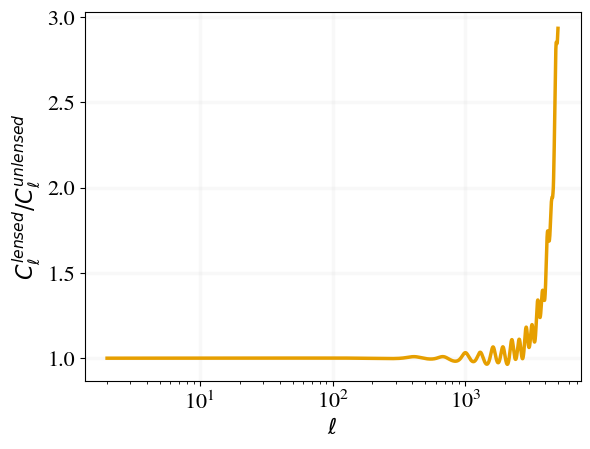

In [71]:
plt.rc("axes", prop_cycle=line_cycler)


plt.semilogx(ells, fiducial_lensing, label = f"CAMB", lw=2.5)

#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
#plt.legend()

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_lensing_tail.pdf", format="pdf", bbox_inches='tight')

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/1044998282.py:19: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
/tmp/ipykernel_15643/1044998282.py:20: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/1044998282.py:32: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


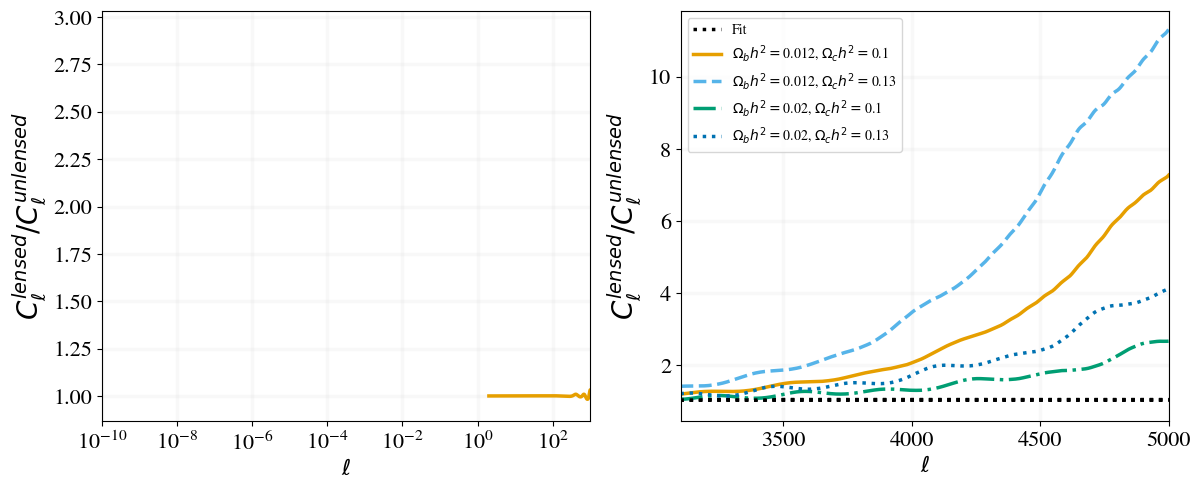

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i == 0:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k",label = rf"Fit", lw=2.5)
    else:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k", lw=2.5)#, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)
    
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)



ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(3100, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/106933412.py:12: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
/tmp/ipykernel_15643/106933412.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/106933412.py:24: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


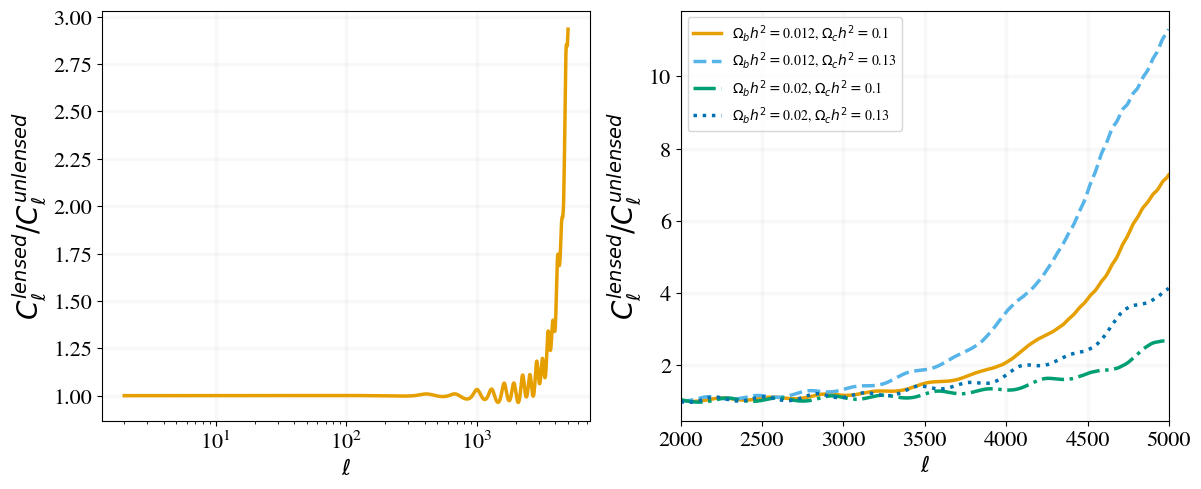

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/2238070813.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$L(\ell)$", fontsize = 16)
/tmp/ipykernel_15643/2238070813.py:22: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/2238070813.py:34: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


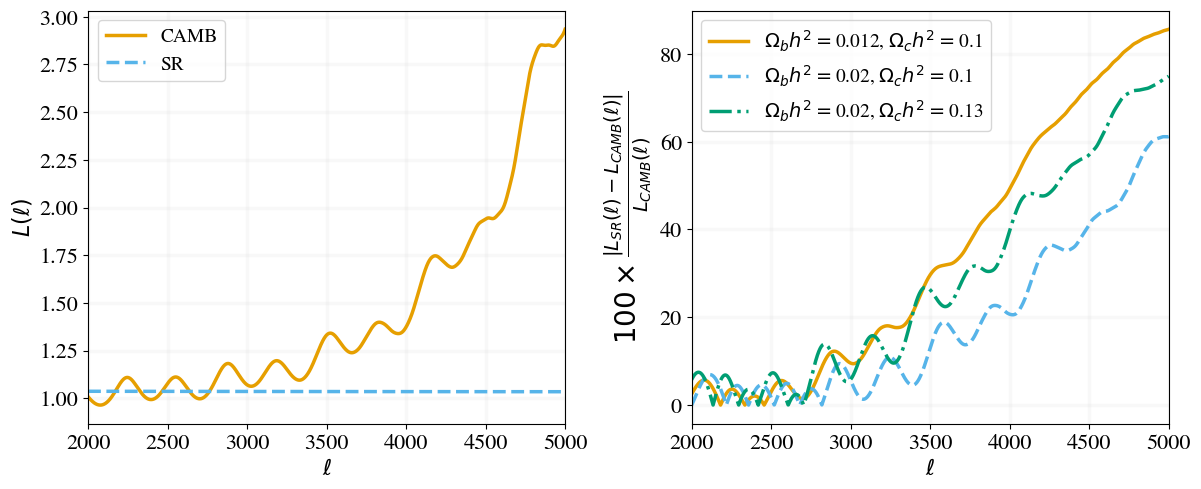

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)


ax[0].plot(ells, fiducial_lensing, lw=2.5, label = "CAMB")
ax[0].plot(ells, lensing_tail_fit(ells, 0.0224, 0.12), lw=2.5, label = "SR")


for i, lensings in enumerate(lensing_tails):
    if i == 0 or i == 2 or i == 3:
        omb = par_arr[i][0]
        omc = par_arr[i][1]
    
        fit = lensing_tail_fit(ells, omb, omc)
        
        ax[1].plot(ells, 100*np.abs(fit-lensings)/lensings, label = rf"$\Omega_bh^2=${round(omb, 4)}, $\Omega_ch^2=${round(omc, 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$L(\ell)$", fontsize = 16)
ax[0].set_xlabel("$\ell$", fontsize = 16)

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[0].set_xlim(2000, 5000)
ax[1].set_xlim(2000, 5000)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)


ax[1].set_ylabel(r"$100\times\frac{|L_{SR}(\ell) - L_{CAMB}(\ell)|}{L_{CAMB}(\ell)}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[0].legend(fontsize = 14)

ax[1].legend(fontsize = 14)

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("lensing_tail_errors.pdf", format="pdf", bbox_inches='tight')

In [55]:


def average_error(omb, omc):
    ells_2000 = np.array([ell for ell in range(3200, 5000)])

    n_ells = len(ells_2000)
    
    pars = camb.set_params(H0 = 67.4, ombh2 = omb, omch2 = omc, lmax=5000)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    camb_lensing = powers['total'][3200:5000, 0]/ powers['unlensed_total'][3200:5000, 0]

    fit = lensing_tail_fit(ells_2000, omb, omc)

    errs = 100*np.abs(fit-camb_lensing)/camb_lensing

    return errs.sum()/n_ells



In [22]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

for omb in ombh2vals:
    for omc in omch2vals:
        print(f"omb = {omb}, omc = {omc}, avg_error: {average_error(omb, omc)}")


omb = 0.012, omc = 0.1, avg_error: 14.869632560167288
omb = 0.012, omc = 0.13, avg_error: 7.954793567299639
omb = 0.02, omc = 0.1, avg_error: 20.80238904598929
omb = 0.02, omc = 0.13, avg_error: 15.241884766404421


In [21]:
ombh2_vals_meshgrid = np.linspace(0.006, 0.04, 10)
omch2_vals_meshgrid = np.linspace(0.05, 0.3, 10)

lensing_avg_error = np.zeros((10, 10))

for i, omb in enumerate(ombh2_vals_meshgrid):
    for j, omc in enumerate(omch2_vals_meshgrid):
        
        print(f"currently: {10*i + j + 1}/100")
        
        lensing_avg_error[i, j] = average_error(omb, omc)

currently: 1/100
currently: 2/100
currently: 3/100
currently: 4/100
currently: 5/100
currently: 6/100
currently: 7/100
currently: 8/100
currently: 9/100
currently: 10/100
currently: 11/100
currently: 12/100
currently: 13/100
currently: 14/100
currently: 15/100
currently: 16/100
currently: 17/100
currently: 18/100
currently: 19/100
currently: 20/100
currently: 21/100
currently: 22/100
currently: 23/100
currently: 24/100
currently: 25/100
currently: 26/100
currently: 27/100
currently: 28/100
currently: 29/100
currently: 30/100
currently: 31/100
currently: 32/100
currently: 33/100
currently: 34/100
currently: 35/100
currently: 36/100
currently: 37/100
currently: 38/100
currently: 39/100
currently: 40/100
currently: 41/100
currently: 42/100
currently: 43/100
currently: 44/100
currently: 45/100
currently: 46/100
currently: 47/100
currently: 48/100
currently: 49/100
currently: 50/100
currently: 51/100
currently: 52/100
currently: 53/100
currently: 54/100
currently: 55/100
currently: 56/100
c

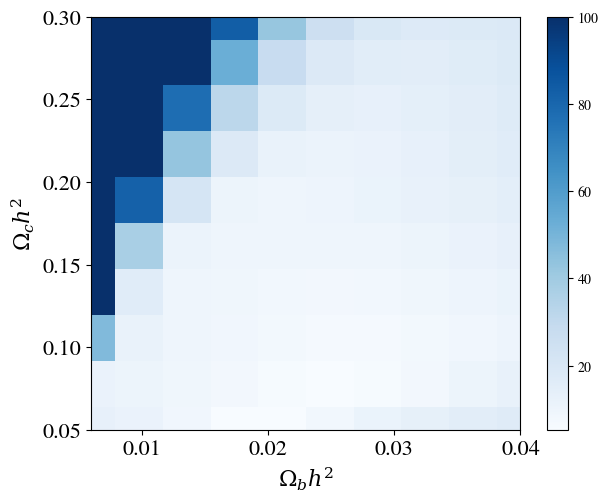

In [22]:
x, y = np.meshgrid(omch2_vals_meshgrid, ombh2_vals_meshgrid)

fig, ax = plt.subplots(1, 1)

z1 = lensing_avg_error

c = ax.pcolormesh(y, x, z1, cmap='Blues', vmax = 100)
ax.axis([y.min(), y.max(), x.min(), x.max() ])

#ax.set_title('EH', fontsize = 16, fontname="Helvetica")

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.tight_layout()

fig.colorbar(c, ax=ax)

ax.set_ylabel(r"$\Omega_c h^2$", fontsize = 16)
ax.set_xlabel(r"$\Omega_b h^2$", fontsize = 16)

plt.savefig("lensing_tail_errors_grid.pdf", format="pdf", bbox_inches='tight')

In [23]:
pars     = np.load('CL_data/parameter_test2.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [24]:
lensing_tails = lensed/unlensed

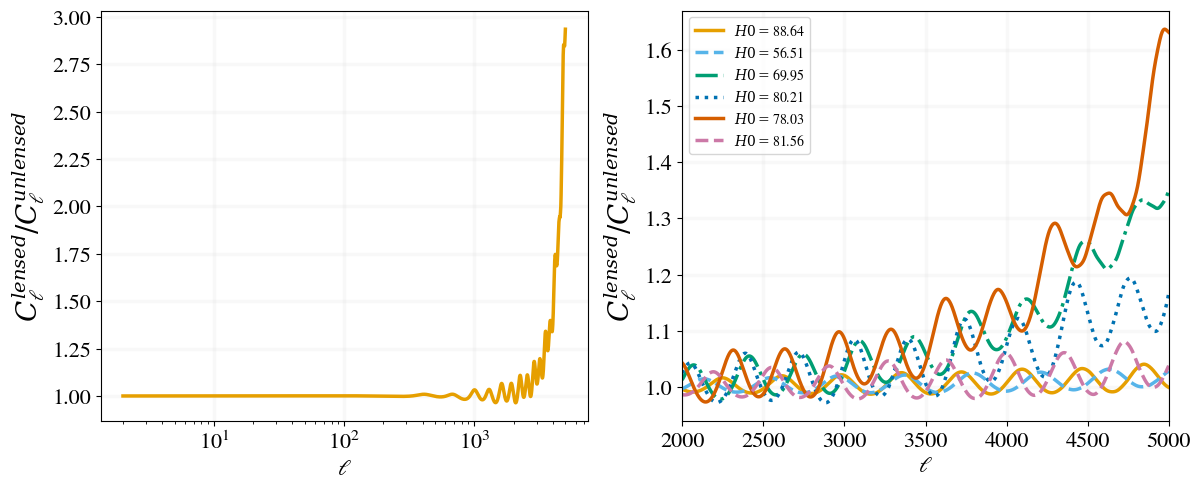

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i <=5 :
        ax[1].plot(ells, lensings, label = rf"$H0=${round(pars[i, 0], 2)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

#ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')